In [45]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Online Retail.csv to Online Retail.csv


In [20]:
clv_data = pd.read_csv("Online Retail.csv", encoding="cp1252")

In [21]:
clv_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [22]:
clv_data.shape

(541909, 8)

In [23]:
clv_data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [24]:
clv_data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [25]:
import pandas as pd

# Convert InvoiceDate to datetime, remove time (keep only date), and handle errors
clv_data['InvoiceDate'] = pd.to_datetime(clv_data['InvoiceDate'], errors='coerce').dt.normalize()

# Remove rows where CustomerID is missing
clv_data = clv_data[pd.notnull(clv_data['CustomerID'])]

# Keep only records with positive quantity
clv_data = clv_data[clv_data['Quantity'] > 0]

# Calculate total sales
clv_data['Total_Sales'] = clv_data['Quantity'] * clv_data['UnitPrice']

# Keep only necessary columns
necessary_cols = ['CustomerID', 'InvoiceDate', 'Total_Sales']
clv_data = clv_data[necessary_cols]

# Preview
clv_data.head()

,CustomerID,InvoiceDate,Total_Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [26]:
#Print records pertaining unique Customer IDs
print(clv_data['CustomerID'].nunique())

4339


In [27]:
#Check the Last order date
last_order_date = clv_data['InvoiceDate'].max()
print(last_order_date)

2011-12-09 00:00:00


In [29]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.5 MB/s eta 0:00:00


In [30]:
from lifetimes.plotting import *
from lifetimes.utils import *
#Built-in utility functions from lifetimes package to transform the transactional data (one row per purchase)
#into summary data (a frequency, recency, age and monetary).
lf_clv_data = summary_data_from_transaction_data(clv_data, 'CustomerID', 'InvoiceDate', monetary_value_col='Total_Sales', observation_period_end='2011-12-09 00:00:00')
lf_clv_data.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value
0,12347.0,4.0,365.0,367.0,457.125
1,12348.0,0.0,0.0,248.0,0.000
2,12350.0,0.0,0.0,310.0,0.000
3,12352.0,1.0,247.0,283.0,311.730
4,12355.0,0.0,0.0,214.0,0.000


count    2997.000000
mean        1.392726
std         2.961860
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        55.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers purchase the item only once: 51.18 %


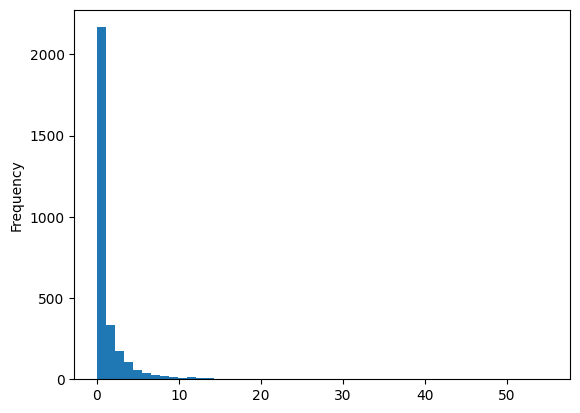

In [32]:
%matplotlib inline
#Create histogram to find out how many customers purchased item only once.
lf_clv_data['frequency'].plot(kind='hist', bins=50)
print(lf_clv_data['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(lf_clv_data['frequency'] == 0)/float(len(lf_clv_data))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

In [39]:
from lifetimes import BetaGeoFitter

# Check if any columns contain NaN or negative values
lf_clv_data = lf_clv_data[(lf_clv_data['frequency'] >= 0) &
                           (lf_clv_data['recency'] >= 0) &
                           (lf_clv_data['T'] >= 0)]

# Set a small penalizer coefficient for regularization to help with convergence
bgf = BetaGeoFitter(penalizer_coef=0.1)  # You can try 0.01 or other small values

# Fit the model
bgf.fit(lf_clv_data['frequency'], lf_clv_data['recency'], lf_clv_data['T'])

# Print the model summary
print(bgf)


<lifetimes.BetaGeoFitter: fitted with 2997 subjects, a: 0.00, alpha: 79.45, b: 0.00, r: 0.51>


In [35]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,5.050942e-01,1.787058e-02,0.470068,0.540121
alpha,7.944728e+01,3.783796e+00,72.031042,86.863520
a,1.522702e-11,7.640372e-07,-0.000001,0.000001
b,2.133187e-08,1.070360e-03,-0.002098,0.002098


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

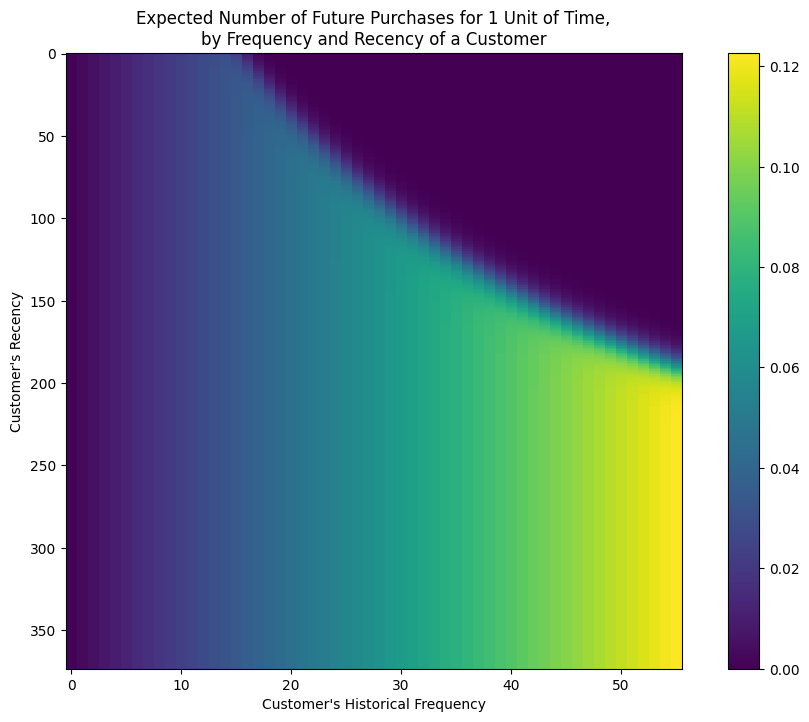

In [36]:
#Visualizing our frequency/recency matrix
%matplotlib inline
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

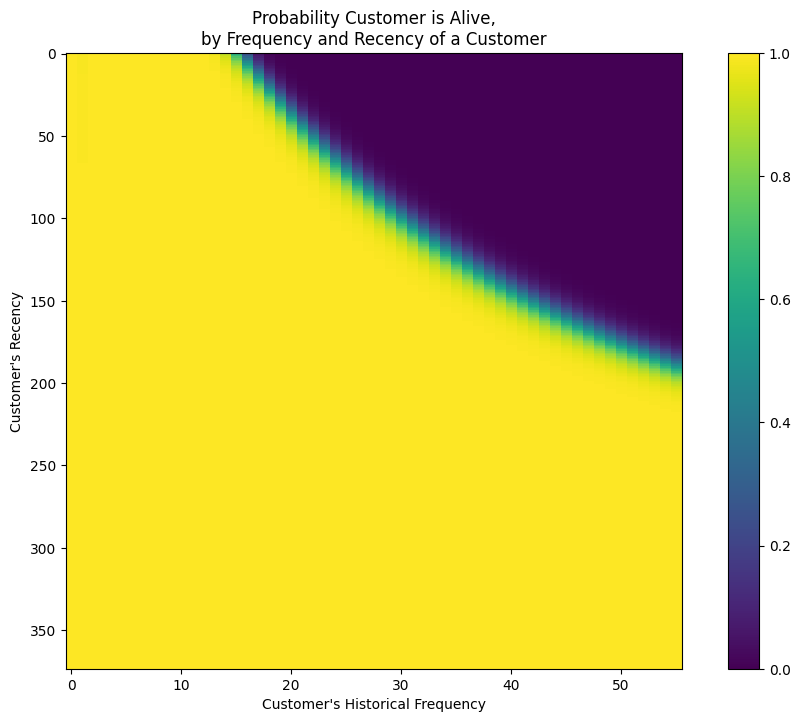

In [40]:
#predict if the customers are surely alive:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [41]:
#Predict future transaction in next 10 days i.e.top 10 customers that the model expects them to make purchases
#in the next 10 days, based on historical data

t = 10
lf_clv_data['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, lf_clv_data['frequency'], lf_clv_data['recency'], lf_clv_data['T']),2)
lf_clv_data.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn
0,12748.0,55.0,373.0,373.0,257.257818,1.23
1,17841.0,45.0,372.0,373.0,373.306667,1.01
2,14911.0,45.0,372.0,373.0,1302.673778,1.01
3,15311.0,39.0,373.0,373.0,816.667179,0.87
4,14606.0,35.0,372.0,373.0,138.835714,0.78
5,12971.0,28.0,369.0,372.0,136.885714,0.63
6,13798.0,25.0,371.0,372.0,855.298400,0.56
7,13089.0,24.0,367.0,369.0,1130.545833,0.55
8,12569.0,15.0,250.0,252.0,145.751333,0.47
9,13468.0,19.0,372.0,373.0,159.855263,0.43


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

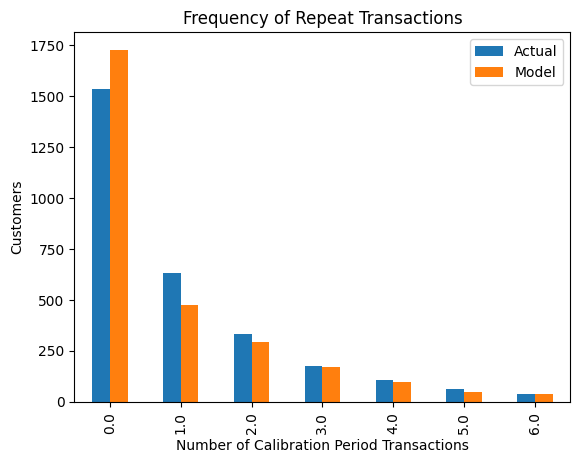

In [42]:
#Assessing model fit
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [46]:
#Customer's future transaction prediction for next 10 days

t = 10
individual = lf_clv_data.loc[14911]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

#OBSERVATION: Our model predicts that customer 14911’s future transaction is appx 1 in 10 days.

np.float64(1.005754618826839)

In [47]:
#Check if there is correlation between monetary value and frequency in order to use gamma gamma model for CLV calculation.
lf_clv_data[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.350125
frequency,0.350125,1.000000


In [48]:
#Shortlist customers who had at least one repeat purchase with the company.
shortlisted_customers = lf_clv_data[lf_clv_data['frequency']>0]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print("The Number of Returning Customers are: ",len(shortlisted_customers))

   CustomerID  frequency  recency      T  monetary_value  pred_num_txn
0     12347.0        4.0    365.0  367.0        457.1250          0.10
1     12352.0        1.0    247.0  283.0        311.7300          0.04
2     12358.0        1.0    149.0  150.0        683.2000          0.07
3     12359.0        2.0    142.0  331.0       1474.1150          0.06
4     12362.0        4.0    152.0  155.0        458.0075          0.19
-----------------------------------------
The Number of Returning Customers are:  1463


In [49]:
#Train gamma-gamma model by taking into account the monetary_value.
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(shortlisted_customers['frequency'],
        shortlisted_customers['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 1463 subjects, p: 2.37, q: 3.20, v: 413.29>


In [50]:
#After applying Gamma-Gamma model, now we can estimate average transaction value for each customer.
print(ggf.conditional_expected_average_profit(
        lf_clv_data['frequency'],
        lf_clv_data['monetary_value']
    ).head(10))

CustomerID
12347.0     454.864768
12348.0     445.127459
12350.0     445.127459
12352.0     375.955247
12355.0     445.127459
12356.0     445.127459
12357.0     445.127459
12358.0     568.578118
12359.0    1147.871792
12362.0     455.581012
dtype: float64


In [51]:
lf_clv_data['pred_txn_value'] = round(ggf.conditional_expected_average_profit(
        lf_clv_data['frequency'],
        lf_clv_data['monetary_value']), 2)
lf_clv_data.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value
0,12347.0,4.0,365.0,367.0,457.125,0.10,454.86
1,12348.0,0.0,0.0,248.0,0.000,0.02,445.13
2,12350.0,0.0,0.0,310.0,0.000,0.01,445.13
3,12352.0,1.0,247.0,283.0,311.730,0.04,375.96
4,12355.0,0.0,0.0,214.0,0.000,0.02,445.13


In [52]:
#Calculate Customer Lifetime Value
lf_clv_data['CLV'] = round(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    lf_clv_data['frequency'],
    lf_clv_data['recency'],
    lf_clv_data['T'],
    lf_clv_data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
), 2)

lf_clv_data.drop(lf_clv_data.iloc[:, 0:6], inplace=True, axis=1)

lf_clv_data.sort_values(by='CLV', ascending=False).head(10).reset_index()

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,CustomerID,CLV
0,18102.0,80992.20
1,14646.0,74045.59
2,14911.0,43649.48
3,14096.0,35530.92
4,17511.0,34428.69
5,16029.0,33280.24
6,12415.0,29153.08
7,14156.0,27401.32
8,16684.0,24517.88
9,17450.0,24291.33
